In [1]:
# Pandas and numpy necessary to do basic data cleaning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

# Import and Clean Data

In [38]:
def make_aer_data(pre1998=True):
    
    # Import
    df = pd.read_stata("./aer_data/aer_data.dta")

    # Clean up data types
    df['year'] = df.year.dt.year
    for x in ['year','fips','stfips']:
        df[x] = df[x].astype(int)

    # Filter data by year and remove the THREE BIGGEST CITIES WHY DO THEY DO THIS
    if pre1998 == True:
        df = df[df.year <= 1988]
    df = df[~((df.stfips == 36) & (df.cofips == 61))] 
    df = df[~((df.stfips == 6) & (df.cofips == 37))]
    df = df[~((df.stfips == 17) & (df.cofips == 31))]

    # Make new variables related to urbanization
    df_1960_pcturban = df.loc[df.year == 1960, ['fips','D_60pcturban_t']] \
                         .drop_duplicates('fips') \
                         .rename(columns={'D_60pcturban_t':'_urb'}) \
                         .fillna(0)
    df = df.merge(df_1960_pcturban, how='left', on='fips')
    df['Durb'] = pd.cut(x=df._urb, bins=[0,1,25,50,75,110], right=False, labels=[0,1,25,50,75])

    # Make straight-up dummy variables
    year_dummies   = pd.get_dummies(df.year, prefix="_Iyear", drop_first=True)
    Durb_dummies   = pd.get_dummies(df.Durb, prefix="_IDurb", drop_first=True)
    fips_dummies   = pd.get_dummies(df.fips, prefix="_Ifips", drop_first=True)
    stfips_dummies = pd.get_dummies(df.stfips, prefix="_Istfips", drop_first=True)

    # Make interaction dummies
    for year in np.sort(df.year.unique()):
        for Durb in np.sort(df.Durb.unique()):
            if (f"_Iyear_{year}" in year_dummies.columns) & (f"_IDurb_{Durb}" in Durb_dummies.columns):
                df[f"_IyeaXDur_{year}_{Durb}"] = year_dummies[f"_Iyear_{year}"]*Durb_dummies[f"_IDurb_{Durb}"]
        for stfips in np.sort(df.stfips.unique()):
            if (f"_Iyear_{year}" in year_dummies.columns) & (f"_Istfips_{stfips}" in stfips_dummies.columns):
                df[f"_IyeaXstf_{year}_{stfips}"] = year_dummies[f"_Iyear_{year}"]*stfips_dummies[f"_Istfips_{stfips}"]
    for fips in np.sort(df.fips.unique()):
        df[f"_IfipXyea_{fips}"] = np.where((df['fips']) == fips, df['year'], 0)

    # Make did1 dummies
    for i,did1 in enumerate(np.sort(df.did1.unique())):
        if did1 != -1:
            df[f"_DDdid1_{i+1}"] = np.where(df['did1'] == did1, 1, 0)

    # Make exp1 dummies
    for i,exp1 in enumerate(np.sort(df.exp1.unique())):
        if exp1 != -1:
            df[f"_Texp1_{i+1}"] = np.where(df['exp1'] == exp1, 1, 0)

    # Make exp2 dummies
    for i,exp2 in enumerate(np.sort(df.exp2.unique())):
        if exp2 != -1:
            df[f"_Texp2_{i+1}"] = np.where(df['exp2'] == exp2, 1, 0)

#     # Make exp1_1998 dummies and rename to not confuse me
#     for i,exp1_1998 in enumerate(np.sort(df.exp1_1998.unique())):
#         if exp1_1998 != -1:
#             df[f"_Texp3_{i+1}"] = np.where(df['exp1_1998'] == exp1_1998, 1, 0)

    # Add on year and fips dummies
    df = pd.concat([df,year_dummies],axis=1)
    df = pd.concat([df,fips_dummies],axis=1)

    # Drop missing response values
    df = df[~df['amr'].isna()]

    # Add constant
    df['_const']  = 1
    
    return df

In [39]:
df = make_aer_data()

# Q8(a) - Replication of Table 2, Column 1, Panel A

### Regression Coefficient and SE Estimates

In [3]:
def get_XY_arrays(df,X_cols,Y_var,weight_var,clust_var,fe=True):
        
    # Remove fixed effect means
    fe_df = copy.deepcopy(df)        

    if fe==True:
        grouped_df = df.groupby(clust_var)
        for x_col in X_cols:
            fe_df[x_col] = df[x_col]-grouped_df[x_col].transform('mean')   
        fe_df[Y_var] = df[Y_var]-grouped_df[Y_var].transform('mean')   
        
    # Make arrays 
    Y      = fe_df[Y_var].to_numpy()[:,None]
    X      = fe_df[X_cols].to_numpy()
    weight = fe_df[weight_var].to_numpy()[:,None]
    N      = X.shape[0]
    K      = X.shape[1]

    return Y,X,weight,N,K,fe_df

In [4]:
def run_aer_regression(df,Y,X,weight,N,K,X_cols,Y_var,weight_var):
    
    # Get beta value
    beta = np.linalg.inv(np.multiply(X,weight).T @ X) @ np.multiply(X,weight).T @ Y
    
    # Build the 'meat' of the cluster sandwich SE estimator
    clust_cov_sum = np.zeros((K,K))
    for clust in np.sort(df[clust_var].unique()):

        # Define data just from cluster
        df_clust     = df[df[clust_var] == clust]
        X_clust      = df_clust[X_cols].to_numpy()
        Y_clust      = df_clust[Y_var].to_numpy()[:,None]
        weight_clust = df_clust[weight_var].to_numpy()[:,None]

        # Do weighted cluster robust SE formula
        u_j  = np.multiply((Y_clust - X_clust @ beta), X_clust)
        wu_j = np.multiply(weight_clust, u_j)
        clust_sum = np.sum(wu_j, axis=0)[None,:]
        clust_cov = clust_sum.T @ clust_sum

        # Add to overall 
        clust_cov_sum += clust_cov

    # Get (X'X)^(-1): the 'bread' of the sandwich
    vcov = np.linalg.inv(np.multiply(X,weight).T @ X)

    # Finite-sample correction
    N_weight= weight.sum()
    n_clust = df[clust_var].unique().shape[0]
    qc      = (n_clust/(n_clust-1))*((N_weight-1)/(N_weight-K))

    # Get standard errors of betas
    beta_SE = np.sqrt(np.diag(qc * vcov @ clust_cov_sum @ vcov))
    
    return beta,beta_SE

In [5]:
# Function for getting stars from z-scores
def get_stars(est,est_SE):
    est = est.ravel()
    est_SE = est_SE.ravel()
    stars_all = []
    for i in range(len(est)):    
        stars   = ""
        esti    = est[i]
        est_SEi = est_SE[i]
        Z       = esti/est_SEi
        if abs(Z) > 1.645:
            stars = stars+"*"
        if abs(Z) > 1.959:
            stars = stars+"*"
        if abs(Z) > 2.576:
            stars = stars+"*"
        stars_all.append(stars)
    return stars_all

In [6]:
# Define covariates to use
_Ifips_cols   = [col for col in df if col.startswith('_Ifips')]
_Iyear_cols   = [col for col in df if col.startswith('_Iyear')]
_IyeaXDu_cols = [col for col in df if col.startswith('_IyeaXDu')]
_DD_cols      = [col for col in df if col.startswith('_DD')]
X_cols        = _Iyear_cols+_IyeaXDu_cols+_DD_cols 
fe_cols       = _Ifips_cols
Y_var         = 'amr'
weight_var    = 'popwt'
clust_var     = 'fips'

Y,X,weight,N,K,fe_df = get_XY_arrays(df, X_cols, Y_var, weight_var, clust_var)

In [7]:
beta,beta_SE = run_aer_regression(fe_df, Y,X,weight, N, K, X_cols, Y_var, weight_var)
beta_stars   = get_stars(beta, beta_SE)

### Output Results to Latex

In [8]:
beta_df = pd.DataFrame.from_dict({"Variable":X_cols,
                                  "Coefficient":[str(np.round(beta.ravel()[i],3))+beta_stars[i] 
                                                 for i in range(beta.shape[0])],
                                  "Standard Error":np.round(beta_SE,3)})
beta_df = beta_df[(beta_df['Variable'] == '_DDdid1_2') |
                  (beta_df['Variable'] == '_DDdid1_4') |
                  (beta_df['Variable'] == '_DDdid1_5') | 
                  (beta_df['Variable'] == '_DDdid1_6')]
beta_df["Variable"] = ["Years -6 to -2","Years 0 to 4","Years 5 to 9","Years 10 to 14"]
beta_df.to_latex("./q8_replication_output/table2_col1_panelA_replication.tex", index=False)

In [9]:
beta_df

,Variable,Coefficient,Standard Error
146,Years -6 to -2,0.034,2.844
147,Years 0 to 4,-5.636,3.540
148,Years 5 to 9,-12.045***,4.569
149,Years 10 to 14,-9.384*,5.639


# Q8(c) - Simpler Specification of Table 2, Column 1, Panel A

### Run Regression

In [10]:
# Define covariates to use - this time without year-urban interaction FEs
X_colsC = _Iyear_cols+_DD_cols 

YC,XC,weightC,NC,KC,fe_dfC = get_XY_arrays(df, X_colsC, Y_var, weight_var, clust_var)

In [11]:
betaC,beta_SEC = run_aer_regression(fe_dfC, YC, XC, weightC, NC, KC, X_colsC, Y_var, weight_var)
beta_starsC    = get_stars(betaC, beta_SEC)

### Output Results to Latex

In [12]:
beta_dfC = pd.DataFrame.from_dict({"Variable":X_colsC,
                                   "Coefficient":[str(np.round(betaC.ravel()[i],3))+beta_starsC[i] 
                                                  for i in range(betaC.shape[0])],
                                   "Standard Error":np.round(beta_SEC,3)})
beta_dfC = beta_dfC[(beta_dfC['Variable'] == '_DDdid1_2') |
                    (beta_dfC['Variable'] == '_DDdid1_4') |
                    (beta_dfC['Variable'] == '_DDdid1_5') | 
                    (beta_dfC['Variable'] == '_DDdid1_6')]
beta_dfC["Variable"] = ["Years -6 to -2","Years 0 to 4","Years 5 to 9","Years 10 to 14"]
beta_dfC.to_latex("./q8_replication_output/q8c_table.tex", index=False)

In [13]:
beta_dfC

,Variable,Coefficient,Standard Error
30,Years -6 to -2,2.49,2.829
31,Years 0 to 4,-6.42*,3.460
32,Years 5 to 9,-10.022**,4.321
33,Years 10 to 14,-2.651,5.087


# Q8(d) - Alternate Versions of Figure 5

### Set Up New Dataset for 3rd Regression on Early CHCs through 1998

In [41]:
# dfc = make_aer_data(pre1998=False)
# dfc = dfc[~((dfc.fips==24510) | (dfc.fips == 51013)) & (dfc.samp8998 == True)]

### Run Regressions

In [51]:
# Define covariates to use - this time without year-urban interaction FEs
_Texp1_cols = [col for col in df if col.startswith('_Texp1')]
_Texp2_cols = [col for col in df if col.startswith('_Texp2')]
# _Texp3_cols = [col for col in df if col.startswith('_Texp3')]
X_colsD1a   = _Iyear_cols+_IyeaXDu_cols+_Texp1_cols
X_colsD1b   = _Iyear_cols+_IyeaXDu_cols+_Texp2_cols
# X_colsD1c   = _Iyear_cols+_IyeaXDu_cols+_Texp3_cols
X_colsD2a   = _Iyear_cols+_Texp1_cols
X_colsD2b   = _Iyear_cols+_Texp2_cols
# X_colsD2c   = _Iyear_cols+_Texp3_cols

# Get matrices for running regressions
YD1a,XD1a,weightD1a,ND1a,KD1a,fe_dfD1a = get_XY_arrays(df,  X_colsD1a, Y_var, weight_var, clust_var)
YD1b,XD1b,weightD1b,ND1b,KD1b,fe_dfD1b = get_XY_arrays(df,  X_colsD1b, Y_var, weight_var, clust_var)
# YD1c,XD1c,weightD1c,ND1c,KD1c,fe_dfD1c = get_XY_arrays(dfc, X_colsD1c, Y_var, weight_var, clust_var)

YD2a,XD2a,weightD2a,ND2a,KD2a,fe_dfD2a = get_XY_arrays(df,  X_colsD2a, Y_var, weight_var, clust_var)
YD2b,XD2b,weightD2b,ND2b,KD2b,fe_dfD2b = get_XY_arrays(df,  X_colsD2b, Y_var, weight_var, clust_var)
# YD2c,XD2c,weightD2c,ND2c,KD2c,fe_dfD2c = get_XY_arrays(dfc, X_colsD2c, Y_var, weight_var, clust_var)

In [52]:
# Run regressions
betaD1a,beta_SED1a = run_aer_regression(fe_dfD1a, YD1a, XD1a, weightD1a, ND1a, KD1a, X_colsD1a, Y_var, weight_var)
betaD1b,beta_SED1b = run_aer_regression(fe_dfD1b, YD1b, XD1b, weightD1b, ND1b, KD1b, X_colsD1b, Y_var, weight_var)
# betaD1c,beta_SED1c = run_aer_regression(fe_dfD1c, YD1c, XD1c, weightD1c, ND1c, KD1c, X_colsD1c, Y_var, weight_var)

betaD2a,beta_SED2a = run_aer_regression(fe_dfD2a, YD2a, XD2a, weightD2a, ND2a, KD2a, X_colsD2a, Y_var, weight_var)
betaD2b,beta_SED2b = run_aer_regression(fe_dfD2b, YD2b, XD2b, weightD2b, ND2b, KD2b, X_colsD2b, Y_var, weight_var)
# betaD2c,beta_SED2c = run_aer_regression(fe_dfD2c, YD2c, XD2c, weightD2c, ND2c, KD2c, X_colsD2c, Y_var, weight_var)

### Format Results for Graphing

In [53]:
# Make dataframe of coefs and standard errors
beta_dfD1a = pd.DataFrame.from_dict({"Variable":X_colsD1a,
                                     "Coefficient":np.round(betaD1a.ravel(),4),
                                     "Standard Error":np.round(beta_SED1a,4)})
beta_dfD1b = pd.DataFrame.from_dict({"Variable":X_colsD1b,
                                     "Coefficient":np.round(betaD1b.ravel(),4),
                                     "Standard Error":np.round(beta_SED1b,4),})
# beta_dfD1c = pd.DataFrame.from_dict({"Variable":X_colsD1c,
#                                      "Coefficient":np.round(betaD1c.ravel(),4),
#                                      "Standard Error":np.round(beta_SED1c,4),})
beta_dfD2a = pd.DataFrame.from_dict({"Variable":X_colsD2a,
                                     "Coefficient":np.round(betaD2a.ravel(),4),
                                     "Standard Error":np.round(beta_SED2a,4)})
beta_dfD2b = pd.DataFrame.from_dict({"Variable":X_colsD2b,
                                     "Coefficient":np.round(betaD2b.ravel(),4),
                                     "Standard Error":np.round(beta_SED2b,4),})
# beta_dfD2c = pd.DataFrame.from_dict({"Variable":X_colsD2c,
#                                      "Coefficient":np.round(betaD2c.ravel(),4),
#                                      "Standard Error":np.round(beta_SED2c,4),})

beta_dfD1a = beta_dfD1a[beta_dfD1a['Variable'].str.contains('_Texp')]
beta_dfD1b = beta_dfD1b[beta_dfD1b['Variable'].str.contains('_Texp')]
# beta_dfD1c = beta_dfD1c[beta_dfD1c['Variable'].str.contains('_Texp')]
beta_dfD2a = beta_dfD2a[beta_dfD2a['Variable'].str.contains('_Texp')]
beta_dfD2b = beta_dfD2b[beta_dfD2b['Variable'].str.contains('_Texp')]
# beta_dfD2c = beta_dfD2c[beta_dfD2c['Variable'].str.contains('_Texp')]

# Force _Texp1_7 to be 0
newrowa    = pd.DataFrame({'Variable':['_Texp1_7'],'Coefficient':[0.0],'Standard Error':[np.nan]})
newrowb    = pd.DataFrame({'Variable':['_Texp2_7'],'Coefficient':[0.0],'Standard Error':[np.nan]})
newrowc    = pd.DataFrame({'Variable':['_Texp3_7'],'Coefficient':[0.0],'Standard Error':[np.nan]})
beta_dfD1a = pd.concat((beta_dfD1a,newrowa))
beta_dfD2a = pd.concat((beta_dfD2a,newrowa))
beta_dfD1b = pd.concat((beta_dfD1b,newrowb))
beta_dfD2b = pd.concat((beta_dfD2b,newrowb))
# beta_dfD1c = pd.concat((beta_dfD1c,newrowb))
# beta_dfD2c = pd.concat((beta_dfD2c,newrowb))

# Make time variable for graphs
beta_dfD1a['Time'] = beta_dfD1a['Variable'].str.extract(r'_([0-9]+)$').astype(int)
beta_dfD2a['Time'] = beta_dfD2a['Variable'].str.extract(r'_([0-9]+)$').astype(int)
beta_dfD1b['Time'] = beta_dfD1b['Variable'].str.extract(r'_([0-9]+)$').astype(int)
beta_dfD2b['Time'] = beta_dfD2b['Variable'].str.extract(r'_([0-9]+)$').astype(int)
# beta_dfD1c['Time'] = beta_dfD1c['Variable'].str.extract(r'_([0-9]+)$').astype(int)
# beta_dfD2c['Time'] = beta_dfD2c['Variable'].str.extract(r'_([0-9]+)$').astype(int)

beta_dfD1a = beta_dfD1a.sort_values('Time').reset_index(drop=True)
beta_dfD2a = beta_dfD2a.sort_values('Time').reset_index(drop=True)
beta_dfD1b = beta_dfD1b.sort_values('Time').reset_index(drop=True)
beta_dfD2b = beta_dfD2b.sort_values('Time').reset_index(drop=True)
# beta_dfD1c = beta_dfD1c.sort_values('Time').reset_index(drop=True)
# beta_dfD2c = beta_dfD2c.sort_values('Time').reset_index(drop=True)

beta_dfD1a['Time'] = beta_dfD1a['Time']-8
beta_dfD2a['Time'] = beta_dfD2a['Time']-8
beta_dfD1b['Time'] = beta_dfD1b['Time']-8
beta_dfD2b['Time'] = beta_dfD2b['Time']-8
# beta_dfD1c['Time'] = beta_dfD1c['Time']-8
# beta_dfD2c['Time'] = beta_dfD2c['Time']-8

# Get upper and lower confidence bounds
beta_dfD1a['Upper CI'] = beta_dfD1a['Coefficient']+1.96*beta_dfD1a['Standard Error']
beta_dfD1a['Lower CI'] = beta_dfD1a['Coefficient']-1.96*beta_dfD1a['Standard Error']
beta_dfD2a['Upper CI'] = beta_dfD2a['Coefficient']+1.96*beta_dfD2a['Standard Error']
beta_dfD2a['Lower CI'] = beta_dfD2a['Coefficient']-1.96*beta_dfD2a['Standard Error']

### Make Graphs

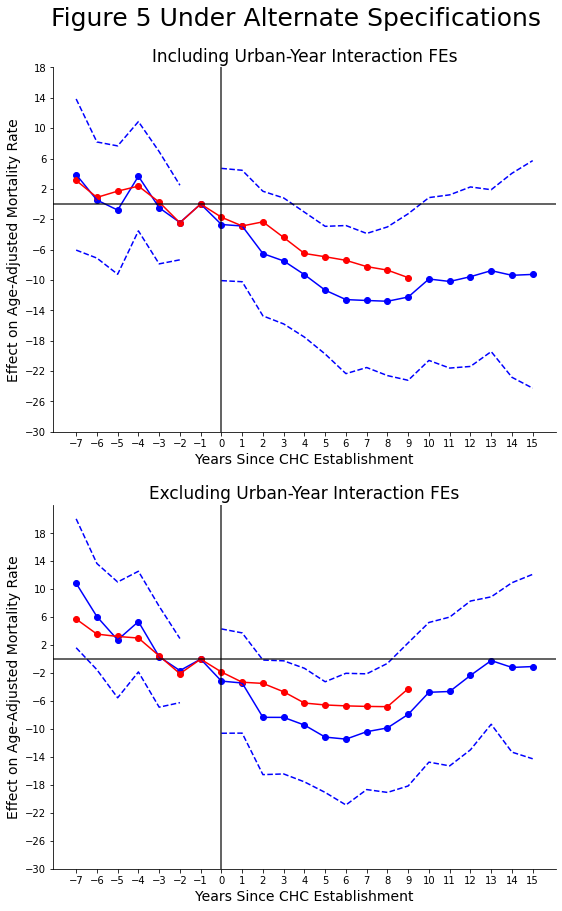

In [54]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(9,14))
ax     = ax.flatten()

# Formatting stuff
plt.subplots_adjust(top=0.92)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Plot 1 main stuff
ax[0].plot(beta_dfD1a['Time'], beta_dfD1a['Coefficient'], color='blue')
ax[0].scatter(beta_dfD1a['Time'], beta_dfD1a['Coefficient'], color='blue')
ax[0].plot(beta_dfD1a['Time'], beta_dfD1a['Upper CI'], linestyle='dashed', color='blue')
ax[0].plot(beta_dfD1a['Time'], beta_dfD1a['Lower CI'], linestyle='dashed', color='blue')
ax[0].plot(beta_dfD1b['Time'], beta_dfD1b['Coefficient'], color='red')
ax[0].scatter(beta_dfD1b['Time'], beta_dfD1b['Coefficient'], color='red')
# ax[0].plot(beta_dfD1c['Time'], beta_dfD1c['Coefficient'], color='green')
# ax[0].scatter(beta_dfD1c['Time'], beta_dfD1c['Coefficient'], color='green')

# Plot 2 main stuff
ax[1].plot(beta_dfD2a['Time'], beta_dfD2a['Coefficient'], color='blue')
ax[1].scatter(beta_dfD2a['Time'], beta_dfD2a['Coefficient'], color='blue')
ax[1].plot(beta_dfD2a['Time'], beta_dfD2a['Upper CI'], linestyle='dashed', color='blue')
ax[1].plot(beta_dfD2a['Time'], beta_dfD2a['Lower CI'], linestyle='dashed', color='blue')
ax[1].plot(beta_dfD2b['Time'], beta_dfD2b['Coefficient'], color='red')
ax[1].scatter(beta_dfD2b['Time'], beta_dfD2b['Coefficient'], color='red')
# ax[1].plot(beta_dfD2c['Time'], beta_dfD2c['Coefficient'], color='green')
# ax[1].scatter(beta_dfD2c['Time'], beta_dfD2c['Coefficient'], color='green')

# Vertical/horizontal lines
ax[0].axhline(y=0, color='black', linestyle='solid', alpha=0.8)
ax[0].axvline(x=0, color='black', linestyle='solid', alpha=0.8)
ax[1].axhline(y=0, color='black', linestyle='solid', alpha=0.8)
ax[1].axvline(x=0, color='black', linestyle='solid', alpha=0.8)

# Axis mess
ax[0].set_xticks(np.arange(-7,16,1))
ax[0].set_yticks(np.arange(-30,22,4))
ax[0].set_xlabel("Years Since CHC Establishment", size=14)
ax[0].set_ylabel("Effect on Age-Adjusted Mortality Rate", size=14)
ax[1].set_xticks(np.arange(-7,16,1))
ax[1].set_yticks(np.arange(-30,22,4))
ax[1].set_xlabel("Years Since CHC Establishment", size=14)
ax[1].set_ylabel("Effect on Age-Adjusted Mortality Rate", size=14)

# Titles
ax[0].set_title("Including Urban-Year Interaction FEs", size=17)
ax[1].set_title("\n\nExcluding Urban-Year Interaction FEs", size=17)
plt.suptitle("Figure 5 Under Alternate Specifications", size=25)

plt.savefig("./q8_replication_output/figure5_alt.png")
plt.show()

# Q8(e) - Direct Approach

In [93]:
df = make_aer_data()

In [109]:
def run_simple_regression(X,Y,weight):
    beta = np.linalg.inv(np.multiply(X,weight).T @ X) @ np.multiply(X,weight).T @ Y
    return beta

In [94]:
# COHORT = chc_year_exp
# TIME = year
# UNIT = fips

In [95]:
# Fix never treated to have cohort = infinity
df['cohort'] = np.where(df['chc_year_exp'].isna(), np.inf, df['chc_year_exp'])

In [96]:
# EARLIEST YEAR IN DATA = 1959
# LATEST YEAR IN DATA   = 1988
# EARLIEST COHORT       = 1965
# LATEST COHORT         = 1980 (plus never treateds)

t1 = 1978
for i in range(e1)
e1 = 1974


In [117]:
# Make data frame for regression
df['kit1'] = (((df['year'] < e1) | (df['year'] == t1)) & ((df['cohort'] == e1) | (df['cohort'] > t1))).astype(int)
df_kit1    = copy.deepcopy(df[df['kit1'] == 1])

# Make indicator variables for regression
df_kit1['t1_ind']    = (df_kit1['year'] == t1).astype(int)
df_kit1['e1_ind']    = (df_kit1['cohort'] == e1).astype(int)
df_kit1['t1_e1_ind'] = ((df_kit1['year'] == t1) & (df_kit1['cohort'] == e1)).astype(int)

# Build matrices for running regression
X_colsE = ['_const','t1_ind','e1_ind','t1_e1_ind']
XE      = np.array(df_kit1[X_colsE])
YE      = np.array(df_kit1[Y_var])[:,None]
weightE = np.array(df_kit1[weight_var])[:,None]

# Get ATT_t(e)
att = run_simple_regression(XE,YE,weightE)[-1,0]
att